### Necessary Imports

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'AutoEncoders')))
from cnn_autoencoder import CNNAutoencoder


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and splitting the Fashion MNIST dataset

In [2]:
base_path = '../../data/external/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'
output_path = '../../data/interim/4/fashion_mnist'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df_split = train_df[:50000]
val_df_split = train_df[50000:]

train_df_split.to_csv(f'{output_path}/fashion-mnist_train.csv', index=False)
val_df_split.to_csv(f'{output_path}/fashion-mnist_val.csv', index=False)
test_df.to_csv(f'{output_path}/fashion-mnist_test.csv', index=False)

print("Data shuffled, split, and saved successfully.")


Data shuffled, split, and saved successfully.


#### Visualizing images from the dataset to see different kinds of clothings and the labels assigned to them

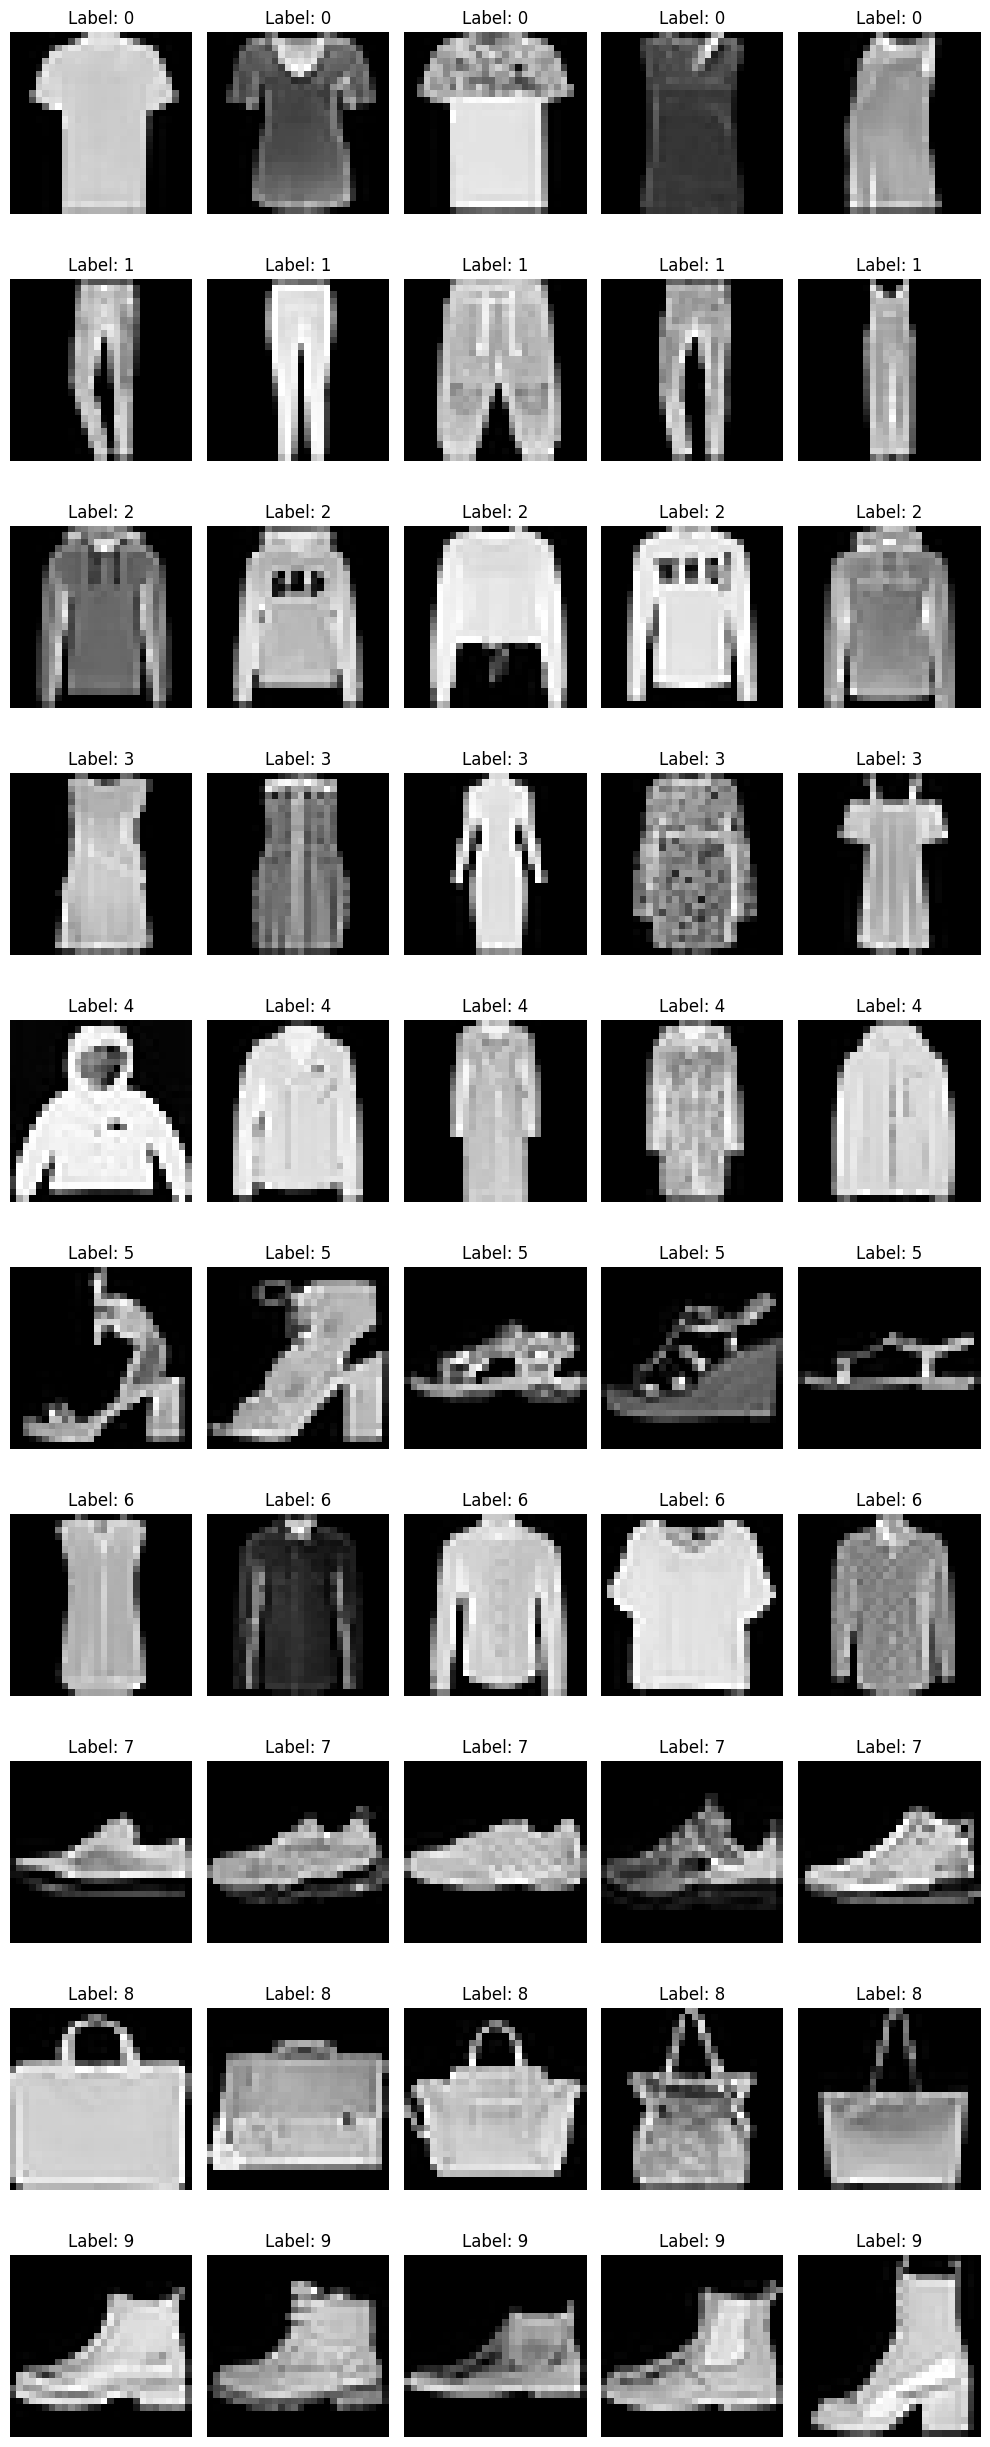

In [3]:
num_labels = 10 
fig, axes = plt.subplots(num_labels, 5, figsize=(10, num_labels * 2.5))

for label in range(num_labels):
    images = train_df[train_df.iloc[:, 0] == label].iloc[:, 1:].values[:5] 
    for j, image in enumerate(images):
        image_reshaped = image.reshape(28, 28)
        axes[label, j].imshow(image_reshaped, cmap='gray')
        axes[label, j].set_title(f'Label: {label}')
        axes[label, j].axis('off')
plt.tight_layout()
plt.show()

#### Listing the clothing type represented by each class

0. **T-shirt**

1. **Trousers**

2. **Sweater**: This looks like warm clothing, mostly without a zipper.

3. **Dress**

4. **Jackets**: This looks like warm clothing, with what seems like zippers in most cases.

5. **Sandals**: The images shows open footwear, like heels and wedges.

6. **Shirts/Polos**: This looks like a collared shirt with buttons down the front.

7. **Sneakers**: These appear to be athletic shoes.

8. **Bag**: These resemble purses or handbags.

9. **Boots**: These look like footwear but are higher than the sneakers.

### Loading the data

In [2]:
base_path = '../../data/interim/4/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
val_path = f'{base_path}/fashion-mnist_val.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'

def load_fashion_data():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_train = train_df.iloc[:, 0].values  
    
    X_val = val_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_val = val_df.iloc[:, 0].values  
    
    X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_test = test_df.iloc[:, 0].values  
    
    return (train_df, val_df, test_df), (X_train, y_train, X_val, y_val, X_test, y_test)

class MultiMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)  
        image = Image.fromarray(image)  
        if self.transform:
            image = self.transform(image)
        
        return image, label

(dataframes, (X_train, y_train, X_val, y_val, X_test, y_test)) = load_fashion_data()

transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 32
train_dataset = MultiMNISTDataset(dataframes[0], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultiMNISTDataset(dataframes[1], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = MultiMNISTDataset(dataframes[2], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Implementing the CnnAutoencoder class

In [5]:
model = CNNAutoencoder(device=device).to(device)
model.fit(train_loader, num_epochs=10, learning_rate=0.001)
model.evaluate(test_loader)

Epoch [1/10]: 100%|██████████| 1563/1563 [00:26<00:00, 59.75batch/s]


Epoch [1/10], Loss: 0.0161


Epoch [2/10]: 100%|██████████| 1563/1563 [00:28<00:00, 55.39batch/s]


Epoch [2/10], Loss: 0.0074


Epoch [3/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.70batch/s]


Epoch [3/10], Loss: 0.0060


Epoch [4/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.68batch/s]


Epoch [4/10], Loss: 0.0054


Epoch [5/10]: 100%|██████████| 1563/1563 [00:28<00:00, 55.25batch/s]


Epoch [5/10], Loss: 0.0050


Epoch [6/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.54batch/s]


Epoch [6/10], Loss: 0.0047


Epoch [7/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.61batch/s]


Epoch [7/10], Loss: 0.0045


Epoch [8/10]: 100%|██████████| 1563/1563 [00:30<00:00, 51.85batch/s]


Epoch [8/10], Loss: 0.0044


Epoch [9/10]: 100%|██████████| 1563/1563 [00:31<00:00, 50.24batch/s]


Epoch [9/10], Loss: 0.0043


Epoch [10/10]: 100%|██████████| 1563/1563 [00:29<00:00, 53.21batch/s]


Epoch [10/10], Loss: 0.0042


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 115.77batch/s]

Test Loss: 0.0043


0.004260165427625179

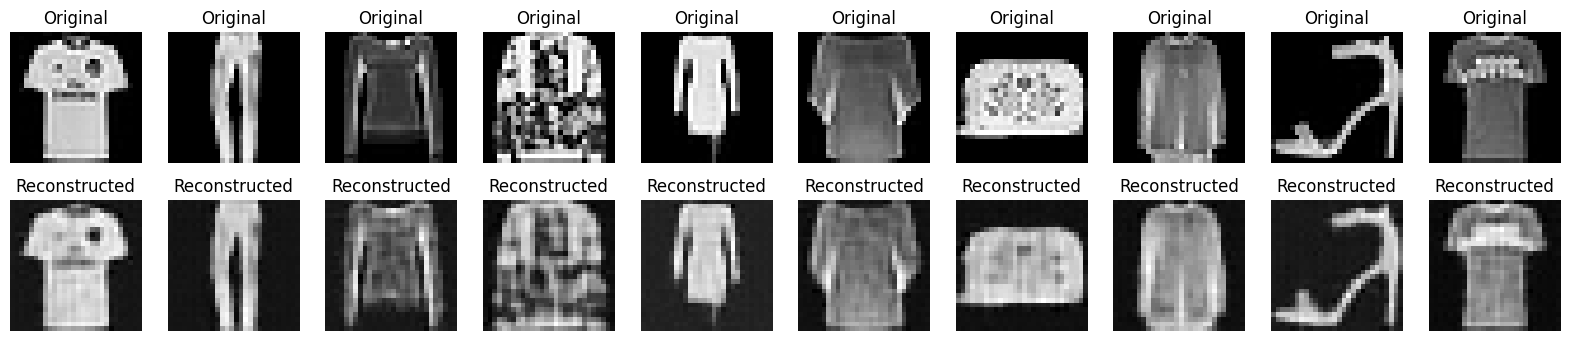

In [6]:
import matplotlib.pyplot as plt

def show_reconstructed_images(model, data_loader, num_images=10):
    model.eval()
    
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images]  
    images = images.to(device)
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

show_reconstructed_images(model, test_loader, num_images=10)


#### Autoencoder Output Quality:
The reconstructed images show good preservation of basic clothing shapes and silhouettes while losing finer details. Essential structural elements like collars, sleeves, and pant legs remain identifiable, but text patterns and textures are notably smoothed out. This level of reconstruction is sufficient for distinguishing clothing categories while demonstrating expected information compression in the latent space.

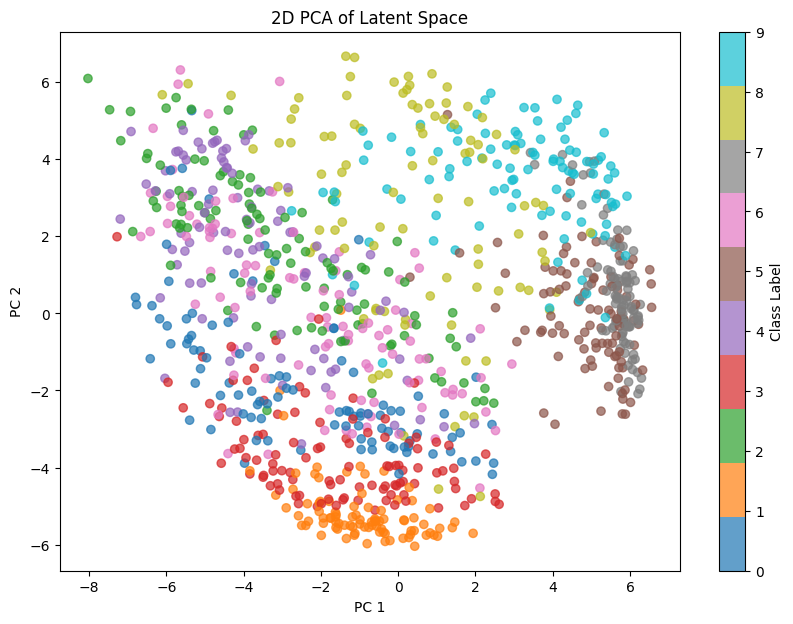

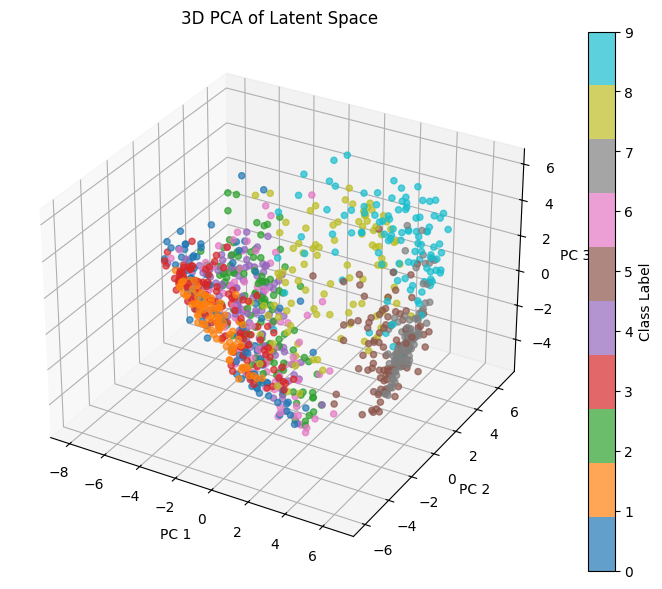

In [7]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(model, test_loader)


### Latent Space Analysis:

The PCA visualizations indicate notable clustering of fashion items:

- Footwear items, such as Sandals, Boots and Sneakers, are grouped closely, reflecting their functional similarities.Sandls and Sneakers have overlaps in the 3D space.
- Full-body garments like Jackets and Sweaters are also positioned near each other.
- Bags are distinctly clustered.
- A clear clustering can be seen between clothing items, footwear and bgs.
- There is a proximity between Trousers and Dresses, possibly due to both being full-length items, but th clusters are distinct enough.

### Hyperparameter Tuning

Training model 1/4 with params: {'learning_rate': 0.0025, 'kernel_sizes': [3, 7, 7], 'num_filters': [32, 64, 32], 'optimizer': 'sgd'}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:40<00:00, 38.67batch/s]


Epoch [1/10], Loss: 0.1361


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 82.38batch/s] 


Validation Loss: 0.1215


Epoch [2/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.97batch/s]


Epoch [2/10], Loss: 0.1217


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 77.80batch/s] 


Validation Loss: 0.1209


Epoch [3/10]: 100%|██████████| 1563/1563 [00:42<00:00, 36.85batch/s]


Epoch [3/10], Loss: 0.1209


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 67.97batch/s] 


Validation Loss: 0.1199


Epoch [4/10]: 100%|██████████| 1563/1563 [00:45<00:00, 34.54batch/s]


Epoch [4/10], Loss: 0.1197


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 76.25batch/s]


Validation Loss: 0.1182


Epoch [5/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.28batch/s]


Epoch [5/10], Loss: 0.1174


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 77.56batch/s]


Validation Loss: 0.1154


Epoch [6/10]: 100%|██████████| 1563/1563 [00:42<00:00, 36.57batch/s]


Epoch [6/10], Loss: 0.1140


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 57.98batch/s]


Validation Loss: 0.1113


Epoch [7/10]: 100%|██████████| 1563/1563 [00:39<00:00, 39.32batch/s]


Epoch [7/10], Loss: 0.1092


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 73.97batch/s]


Validation Loss: 0.1060


Epoch [8/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.37batch/s]


Epoch [8/10], Loss: 0.1038


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 76.41batch/s] 


Validation Loss: 0.1007


Epoch [9/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.68batch/s]


Epoch [9/10], Loss: 0.0990


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 82.62batch/s] 


Validation Loss: 0.0965


Epoch [10/10]: 100%|██████████| 1563/1563 [00:39<00:00, 39.20batch/s]


Epoch [10/10], Loss: 0.0956


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 76.82batch/s] 


Validation Loss: 0.0938
Training model 2/4 with params: {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:32<00:00, 48.30batch/s]


Epoch [1/10], Loss: 0.0218


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.77batch/s]


Validation Loss: 0.0105


Epoch [2/10]: 100%|██████████| 1563/1563 [00:37<00:00, 41.29batch/s]


Epoch [2/10], Loss: 0.0087


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 75.25batch/s]


Validation Loss: 0.0073


Epoch [3/10]: 100%|██████████| 1563/1563 [00:35<00:00, 44.48batch/s]


Epoch [3/10], Loss: 0.0066


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 82.34batch/s] 


Validation Loss: 0.0061


Epoch [4/10]: 100%|██████████| 1563/1563 [00:32<00:00, 47.99batch/s]


Epoch [4/10], Loss: 0.0057


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 102.28batch/s]


Validation Loss: 0.0055


Epoch [5/10]: 100%|██████████| 1563/1563 [00:31<00:00, 49.30batch/s]


Epoch [5/10], Loss: 0.0053


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 88.23batch/s]


Validation Loss: 0.0052


Epoch [6/10]: 100%|██████████| 1563/1563 [00:33<00:00, 46.04batch/s]


Epoch [6/10], Loss: 0.0050


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 87.09batch/s] 


Validation Loss: 0.0049


Epoch [7/10]: 100%|██████████| 1563/1563 [00:34<00:00, 45.51batch/s]


Epoch [7/10], Loss: 0.0048


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 96.16batch/s] 


Validation Loss: 0.0048


Epoch [8/10]: 100%|██████████| 1563/1563 [00:32<00:00, 47.51batch/s]


Epoch [8/10], Loss: 0.0047


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 106.88batch/s]


Validation Loss: 0.0047


Epoch [9/10]: 100%|██████████| 1563/1563 [00:34<00:00, 45.71batch/s]


Epoch [9/10], Loss: 0.0046


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 91.92batch/s] 


Validation Loss: 0.0045


Epoch [10/10]: 100%|██████████| 1563/1563 [00:33<00:00, 47.24batch/s]


Epoch [10/10], Loss: 0.0045


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 96.71batch/s] 


Validation Loss: 0.0045
Training model 3/4 with params: {'learning_rate': 0.0005, 'kernel_sizes': [3, 3, 7], 'num_filters': [8, 16, 32], 'optimizer': 'adam'}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:25<00:00, 60.49batch/s]


Epoch [1/10], Loss: 0.0269


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 99.87batch/s] 


Validation Loss: 0.0155


Epoch [2/10]: 100%|██████████| 1563/1563 [00:25<00:00, 61.31batch/s]


Epoch [2/10], Loss: 0.0137


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 98.75batch/s] 


Validation Loss: 0.0122


Epoch [3/10]: 100%|██████████| 1563/1563 [00:24<00:00, 64.18batch/s]


Epoch [3/10], Loss: 0.0113


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 99.47batch/s] 


Validation Loss: 0.0104


Epoch [4/10]: 100%|██████████| 1563/1563 [00:24<00:00, 63.79batch/s]


Epoch [4/10], Loss: 0.0099


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 105.82batch/s]


Validation Loss: 0.0095


Epoch [5/10]: 100%|██████████| 1563/1563 [00:23<00:00, 67.74batch/s]


Epoch [5/10], Loss: 0.0092


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 112.46batch/s]


Validation Loss: 0.0089


Epoch [6/10]: 100%|██████████| 1563/1563 [00:22<00:00, 70.45batch/s]


Epoch [6/10], Loss: 0.0087


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 136.16batch/s]


Validation Loss: 0.0085


Epoch [7/10]: 100%|██████████| 1563/1563 [00:24<00:00, 64.12batch/s]


Epoch [7/10], Loss: 0.0084


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.09batch/s]


Validation Loss: 0.0082


Epoch [8/10]: 100%|██████████| 1563/1563 [00:24<00:00, 62.58batch/s]


Epoch [8/10], Loss: 0.0081


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 106.40batch/s]


Validation Loss: 0.0080


Epoch [9/10]: 100%|██████████| 1563/1563 [00:23<00:00, 65.25batch/s]


Epoch [9/10], Loss: 0.0079


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 155.90batch/s]


Validation Loss: 0.0079


Epoch [10/10]: 100%|██████████| 1563/1563 [00:23<00:00, 65.23batch/s]


Epoch [10/10], Loss: 0.0077


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 91.59batch/s]


Validation Loss: 0.0077
Training model 4/4 with params: {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 3], 'num_filters': [8, 16, 32], 'optimizer': 'sgd'}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:21<00:00, 73.56batch/s] 


Epoch [1/10], Loss: 0.1781


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 133.37batch/s]


Validation Loss: 0.1251


Epoch [2/10]: 100%|██████████| 1563/1563 [00:16<00:00, 93.78batch/s] 


Epoch [2/10], Loss: 0.1250


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 132.49batch/s]


Validation Loss: 0.1243


Epoch [3/10]: 100%|██████████| 1563/1563 [00:16<00:00, 93.98batch/s] 


Epoch [3/10], Loss: 0.1247


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 118.36batch/s]


Validation Loss: 0.1241


Epoch [4/10]: 100%|██████████| 1563/1563 [00:15<00:00, 97.75batch/s] 


Epoch [4/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 128.14batch/s]


Validation Loss: 0.1241


Epoch [5/10]: 100%|██████████| 1563/1563 [00:15<00:00, 100.59batch/s]


Epoch [5/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 195.05batch/s]


Validation Loss: 0.1241


Epoch [6/10]: 100%|██████████| 1563/1563 [00:17<00:00, 91.38batch/s] 


Epoch [6/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 123.69batch/s]


Validation Loss: 0.1241


Epoch [7/10]: 100%|██████████| 1563/1563 [00:16<00:00, 92.97batch/s] 


Epoch [7/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 113.70batch/s]


Validation Loss: 0.1240


Epoch [8/10]: 100%|██████████| 1563/1563 [00:17<00:00, 88.61batch/s] 


Epoch [8/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 131.75batch/s]


Validation Loss: 0.1240


Epoch [9/10]: 100%|██████████| 1563/1563 [00:16<00:00, 94.11batch/s] 


Epoch [9/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 107.15batch/s]


Validation Loss: 0.1240


Epoch [10/10]: 100%|██████████| 1563/1563 [00:15<00:00, 99.91batch/s] 


Epoch [10/10], Loss: 0.1246


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 143.84batch/s]


Validation Loss: 0.1240
Best validation loss: 0.0045


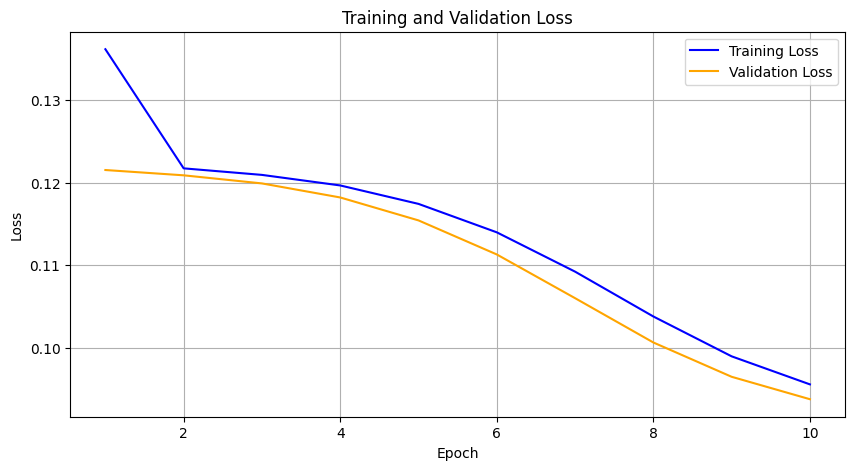

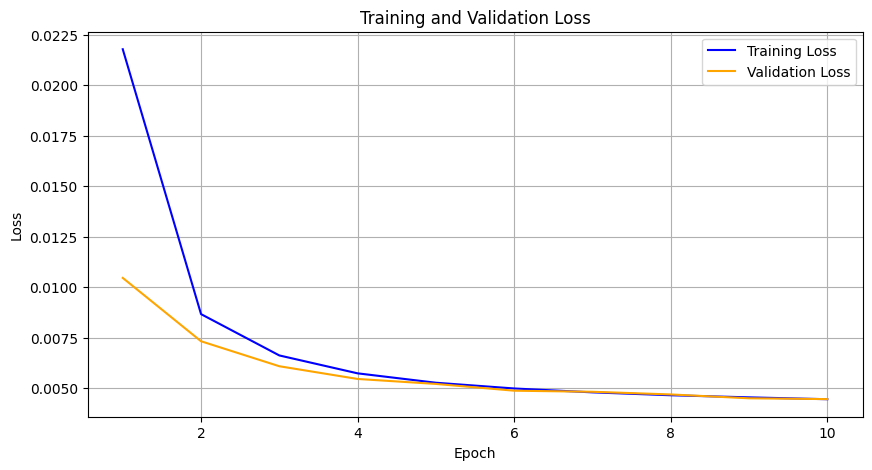

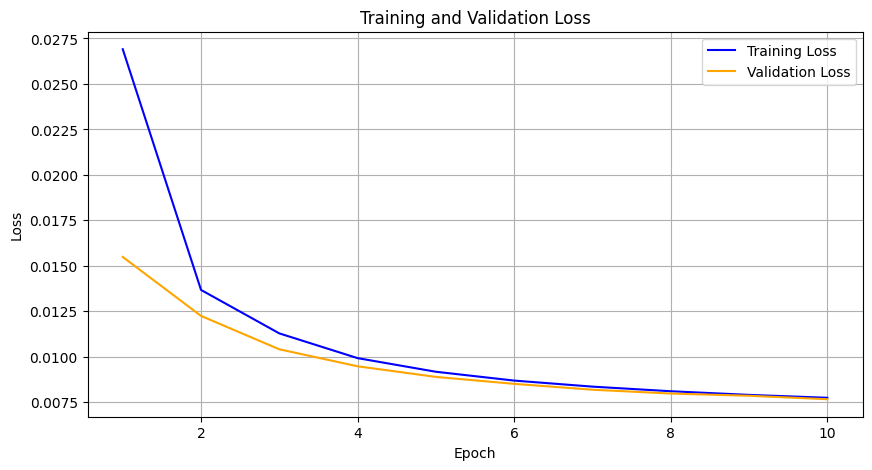

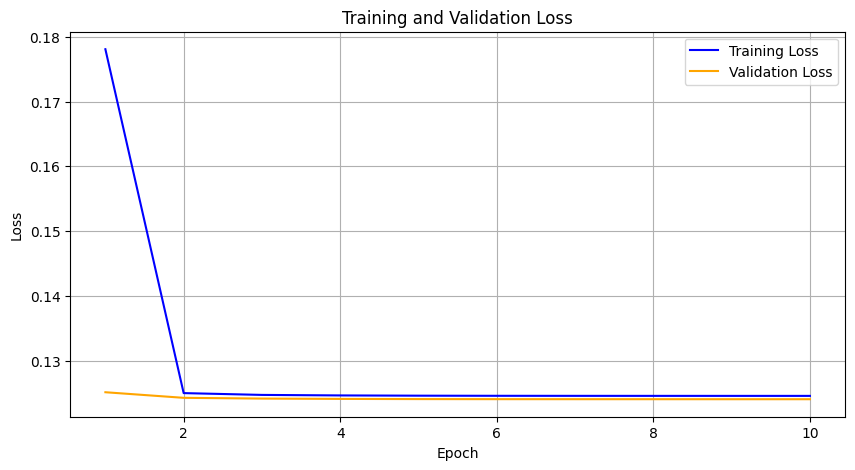

In [6]:
import os

hyperparams = [
    {'learning_rate': 0.0025, 'kernel_sizes': [3, 7, 7], 'num_filters': [32, 64, 32], 'optimizer': 'sgd'},
    {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'},
    {'learning_rate': 0.0005, 'kernel_sizes': [3, 3, 7], 'num_filters': [8, 16, 32], 'optimizer': 'adam'},
    {'learning_rate': 0.001, 'kernel_sizes': [3, 3, 3], 'num_filters': [8, 16, 32], 'optimizer': 'sgd'},
]

os.makedirs('figures/cnn_autoencoder_loss_plots', exist_ok=True)

best_model = None
best_val_loss = float('inf')

for i, params in enumerate(hyperparams):
    print(f"Training model {i + 1}/{len(hyperparams)} with params: {params}")
    
    model = CNNAutoencoder(
        num_filters=params['num_filters'], 
        kernel_sizes=params['kernel_sizes'], 
        activation=nn.ReLU, 
        device=device,
        save_path=f'figures/cnn_autoencoder_loss_plots/model_lr{params["learning_rate"]}_ks{params["kernel_sizes"]}_nf{params["num_filters"]}_opt{params["optimizer"]}.png'
    ).to(device)

    model.fit(train_loader, val_loader=val_loader, num_epochs=10, learning_rate=params['learning_rate'], optimizer_choice=params['optimizer'])
    
    model.plot_losses()
    
    val_loss = model.val_losses[-1] if model.val_losses else float('inf')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print(f'Best validation loss: {best_val_loss:.4f}')


### Identifying the Best Performing Model

##### Best Validtion Loss: 0.0045   
##### Configuration: 
```python
{'learning_rate': 0.001, 'kernel_sizes': [3, 3, 7], 'num_filters': [16, 32, 64], 'optimizer': 'adam'}
```
##### Plot
![Best model](./figures/cnn_autoencoder_loss_plots/model_lr0.001_ks[3,%203,%207]_nf[16,%2032,%2064]_optadam.png)

### Comparing Loss across Latent space Dimension = 64

Training model 1/3 with params: {'num_filters': [8, 16], 'kernel_sizes': [5, 13]}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:20<00:00, 77.38batch/s] 


Epoch [1/10], Loss: 0.0253


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 147.20batch/s]


Validation Loss: 0.0178


Epoch [2/10]: 100%|██████████| 1563/1563 [00:17<00:00, 86.86batch/s] 


Epoch [2/10], Loss: 0.0169


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 130.10batch/s]


Validation Loss: 0.0163


Epoch [3/10]: 100%|██████████| 1563/1563 [00:17<00:00, 91.24batch/s] 


Epoch [3/10], Loss: 0.0159


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 134.02batch/s]


Validation Loss: 0.0157


Epoch [4/10]: 100%|██████████| 1563/1563 [00:17<00:00, 87.57batch/s]


Epoch [4/10], Loss: 0.0155


Evaluating: 100%|██████████| 313/313 [00:01<00:00, 178.00batch/s]


Validation Loss: 0.0154


Epoch [5/10]: 100%|██████████| 1563/1563 [00:25<00:00, 60.80batch/s]


Epoch [5/10], Loss: 0.0152


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.17batch/s] 


Validation Loss: 0.0151


Epoch [6/10]: 100%|██████████| 1563/1563 [00:24<00:00, 64.10batch/s]


Epoch [6/10], Loss: 0.0150


Evaluating: 100%|██████████| 313/313 [00:02<00:00, 108.04batch/s]


Validation Loss: 0.0148


Epoch [7/10]: 100%|██████████| 1563/1563 [00:26<00:00, 58.36batch/s]


Epoch [7/10], Loss: 0.0148


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 91.90batch/s] 


Validation Loss: 0.0147


Epoch [8/10]: 100%|██████████| 1563/1563 [00:26<00:00, 58.35batch/s]


Epoch [8/10], Loss: 0.0147


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 83.52batch/s]


Validation Loss: 0.0146


Epoch [9/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.17batch/s]


Epoch [9/10], Loss: 0.0146


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 89.96batch/s] 


Validation Loss: 0.0145


Epoch [10/10]: 100%|██████████| 1563/1563 [00:27<00:00, 56.47batch/s]


Epoch [10/10], Loss: 0.0145


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 101.08batch/s]


Validation Loss: 0.0143
Latent dimensions = 64
Training model 2/3 with params: {'num_filters': [8, 16, 64], 'kernel_sizes': [3, 7, 7]}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:40<00:00, 38.74batch/s]


Epoch [1/10], Loss: 0.0347


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 83.19batch/s]


Validation Loss: 0.0184


Epoch [2/10]: 100%|██████████| 1563/1563 [00:35<00:00, 43.70batch/s]


Epoch [2/10], Loss: 0.0162


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 83.76batch/s] 


Validation Loss: 0.0146


Epoch [3/10]: 100%|██████████| 1563/1563 [00:35<00:00, 44.25batch/s]


Epoch [3/10], Loss: 0.0137


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 81.74batch/s]


Validation Loss: 0.0132


Epoch [4/10]: 100%|██████████| 1563/1563 [00:39<00:00, 39.44batch/s]


Epoch [4/10], Loss: 0.0127


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 77.94batch/s]


Validation Loss: 0.0124


Epoch [5/10]: 100%|██████████| 1563/1563 [00:38<00:00, 40.92batch/s]


Epoch [5/10], Loss: 0.0122


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 62.86batch/s]


Validation Loss: 0.0120


Epoch [6/10]: 100%|██████████| 1563/1563 [00:37<00:00, 41.49batch/s]


Epoch [6/10], Loss: 0.0119


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 80.55batch/s] 


Validation Loss: 0.0119


Epoch [7/10]: 100%|██████████| 1563/1563 [00:39<00:00, 39.90batch/s]


Epoch [7/10], Loss: 0.0117


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 66.56batch/s]


Validation Loss: 0.0117


Epoch [8/10]: 100%|██████████| 1563/1563 [00:37<00:00, 41.14batch/s]


Epoch [8/10], Loss: 0.0116


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 72.07batch/s] 


Validation Loss: 0.0114


Epoch [9/10]: 100%|██████████| 1563/1563 [00:40<00:00, 38.61batch/s]


Epoch [9/10], Loss: 0.0115


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 61.14batch/s]


Validation Loss: 0.0114


Epoch [10/10]: 100%|██████████| 1563/1563 [00:38<00:00, 40.70batch/s]


Epoch [10/10], Loss: 0.0114


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 68.68batch/s]


Validation Loss: 0.0113
Latent dimensions = 64
Training model 3/3 with params: {'num_filters': [8, 16, 32, 64], 'kernel_sizes': [3, 5, 7, 3]}


Epoch [1/10]: 100%|██████████| 1563/1563 [00:36<00:00, 43.02batch/s]


Epoch [1/10], Loss: 0.0367


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 80.19batch/s] 


Validation Loss: 0.0255


Epoch [2/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.66batch/s]


Epoch [2/10], Loss: 0.0236


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 60.73batch/s]


Validation Loss: 0.0223


Epoch [3/10]: 100%|██████████| 1563/1563 [00:34<00:00, 44.88batch/s]


Epoch [3/10], Loss: 0.0217


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 86.33batch/s] 


Validation Loss: 0.0207


Epoch [4/10]: 100%|██████████| 1563/1563 [00:45<00:00, 34.19batch/s]


Epoch [4/10], Loss: 0.0203


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 74.46batch/s]


Validation Loss: 0.0195


Epoch [5/10]: 100%|██████████| 1563/1563 [00:41<00:00, 37.83batch/s]


Epoch [5/10], Loss: 0.0190


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 70.59batch/s]


Validation Loss: 0.0184


Epoch [6/10]: 100%|██████████| 1563/1563 [00:40<00:00, 38.34batch/s]


Epoch [6/10], Loss: 0.0181


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 68.62batch/s]


Validation Loss: 0.0177


Epoch [7/10]: 100%|██████████| 1563/1563 [00:43<00:00, 36.22batch/s]


Epoch [7/10], Loss: 0.0175


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 69.58batch/s]


Validation Loss: 0.0171


Epoch [8/10]: 100%|██████████| 1563/1563 [00:44<00:00, 34.75batch/s]


Epoch [8/10], Loss: 0.0169


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 80.51batch/s] 


Validation Loss: 0.0166


Epoch [9/10]: 100%|██████████| 1563/1563 [00:42<00:00, 37.12batch/s]


Epoch [9/10], Loss: 0.0165


Evaluating: 100%|██████████| 313/313 [00:05<00:00, 61.69batch/s]


Validation Loss: 0.0164


Epoch [10/10]: 100%|██████████| 1563/1563 [00:43<00:00, 35.72batch/s]


Epoch [10/10], Loss: 0.0162


Evaluating: 100%|██████████| 313/313 [00:04<00:00, 69.34batch/s]


Validation Loss: 0.0160
Latent dimensions = 64
Best validation loss: 0.0113


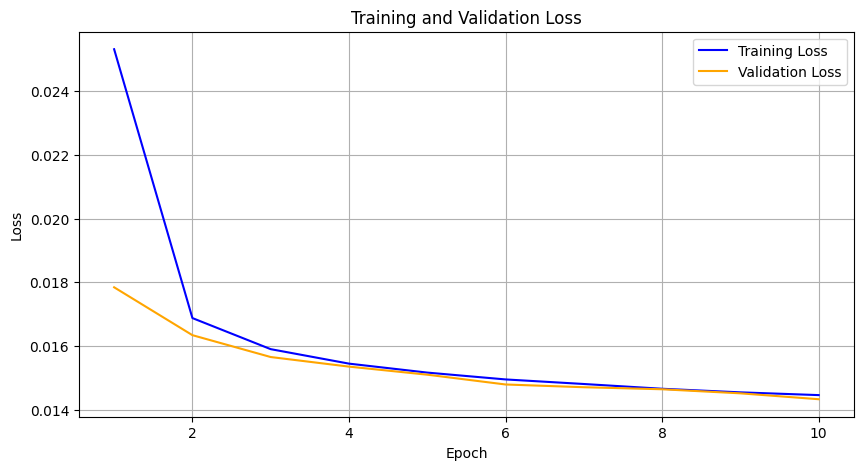

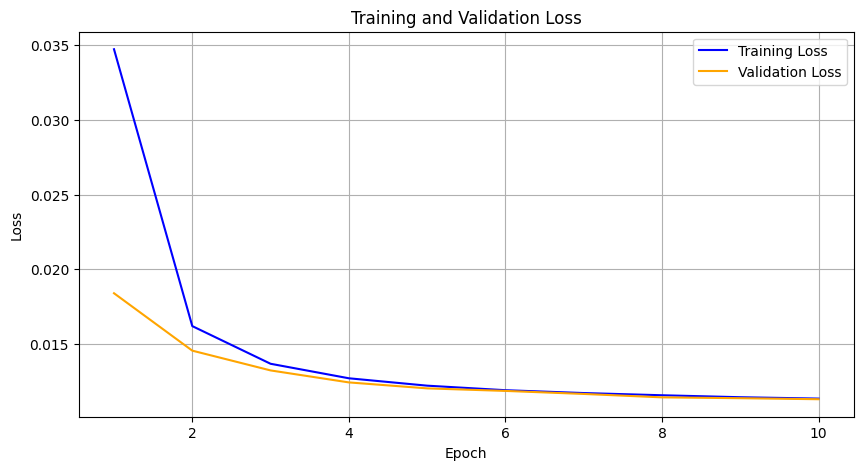

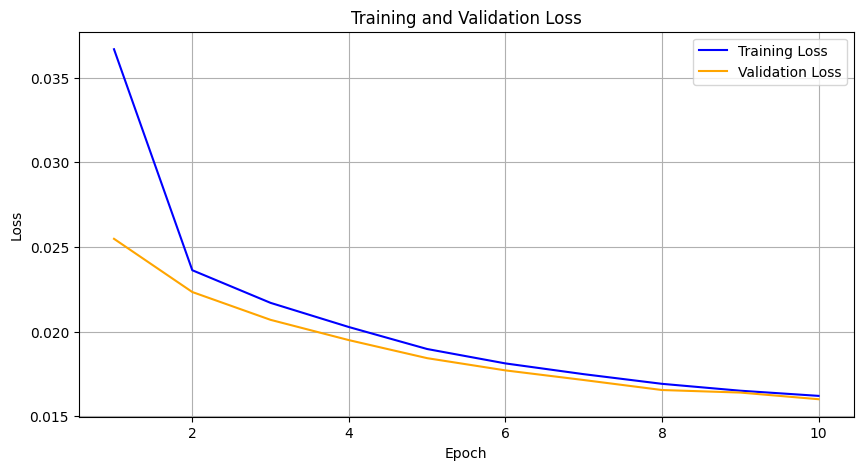

In [9]:
layer_configurations = [
    {'num_filters': [8, 16], 'kernel_sizes': [5, 13]},
    {'num_filters': [8, 16, 64], 'kernel_sizes': [3, 7, 7]},
    {'num_filters': [8, 16, 32, 64], 'kernel_sizes': [3, 5, 7, 3]}
]

os.makedirs('figures/cnn_autoencoder_loss_plots/latent_analysis', exist_ok=True)

best_model_latent_64 = None
best_val_loss_latent_64 = float('inf')

for i, params in enumerate(layer_configurations):
    print(f"Training model {i + 1}/{len(layer_configurations)} with params: {params}")
    
    model = CNNAutoencoder(
        num_filters=params['num_filters'], 
        kernel_sizes=params['kernel_sizes'], 
        device=device,
        save_path=f'figures/cnn_autoencoder_loss_plots/latent_analysis/model_ks{params["kernel_sizes"]}_nf{params["num_filters"]}.png'
    ).to(device)

    model.fit(train_loader, val_loader=val_loader, num_epochs=10)
    
    model.plot_losses()

    x_encoded = []
    model.eval()

    with torch.no_grad():
        for x, _ in train_loader: 
            x = x.to(device)
            encoded = model.encode(x)
            x_encoded.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            break

    x_encoded = np.concatenate(x_encoded)
    print(f"Latent dimensions = {x_encoded.shape[1]}" )

    
    val_loss = model.val_losses[-1] if model.val_losses else float('inf')
    if val_loss < best_val_loss_latent_64:
        best_val_loss_latent_64 = val_loss
        best_model_latent_64 = model

print(f'Best validation loss: {best_val_loss_latent_64:.4f}')


### Analysis of Model Performance with Varying Layer Configurations

#### Model Configurations

| **Model** | **Number of Filters** | **Kernel Sizes** | **Training Loss (Final)** | **Validation Loss (Final)** |
|-----------|-----------------------|-------------------|---------------------------|-----------------------------|
| Model 1   | [8, 16]               | [5, 13]           | 0.0145                    | 0.0143                      |
| Model 2   | [8, 16, 64]           | [3, 7, 7]         | 0.0114                    | 0.0113                      |
| Model 3   | [8, 16, 32, 64]       | [3, 5, 7, 3]      | 0.0162                    | 0.0160                      |


- **Model 1** exhibited a consistent decrease in both training and validation loss over the 10 epochs.The final validation loss of 0.0143 suggests effective generalization.
  
- **Model 2** achieved the lowest training and validation losses, indicating that the addition of an extra layer with more filters improved the model's capacity to learn from the data. 

- **Model 3**, despite having a more complex architecture with an additional layer and varied filter sizes, resulted in higher final losses compared to Model 2. This suggests potential overfitting due to increased model complexity, as indicated by the less pronounced decrease in loss values.

The validation loss values indicate that Model 2 outperformed the others, achieving the best generalization. Model 1 followed closely, while Model 3 had the highest validation loss.

Adding layers and increasing the number of filters generally improves model performance up to a point. Model 2 demonstrates that the optimal configuration can significantly enhance learning capacity and generalization. While deeper models (as seen in Model 3) can capture more complex features, they also risk **overfitting**. This is evident in the less favorable validation performance compared to Model 2. It is possible that becuse Model 3 with more layers will take **longer to converge** due to the increased complexity, it may outperform model 2 given higher number of epochs.


Epoch 1/30, Loss: 0.044513247229222244
Validation Loss: 0.02918266271421156
Epoch 2/30, Loss: 0.025716014778428702
Validation Loss: 0.023132007172869975
Epoch 3/30, Loss: 0.02178477410394354
Validation Loss: 0.020619218597510765
Epoch 4/30, Loss: 0.01998154457383465
Validation Loss: 0.019346379776694296
Epoch 5/30, Loss: 0.018992178210055437
Validation Loss: 0.01860059514327961
Epoch 6/30, Loss: 0.018398238909297163
Validation Loss: 0.018146916338239106
Epoch 7/30, Loss: 0.018020650983836407
Validation Loss: 0.017838213294967053
Epoch 8/30, Loss: 0.017768828407270544
Validation Loss: 0.01762969290504764
Epoch 9/30, Loss: 0.017595724826202048
Validation Loss: 0.01749180634656751
Epoch 10/30, Loss: 0.017474483944110376
Validation Loss: 0.017389744874577635
Epoch 11/30, Loss: 0.01738445291530239
Validation Loss: 0.017306364942268813
Epoch 12/30, Loss: 0.017321312392891728
Validation Loss: 0.017253992083109283
Epoch 13/30, Loss: 0.017274143427819882
Validation Loss: 0.017247858218765184
Ep

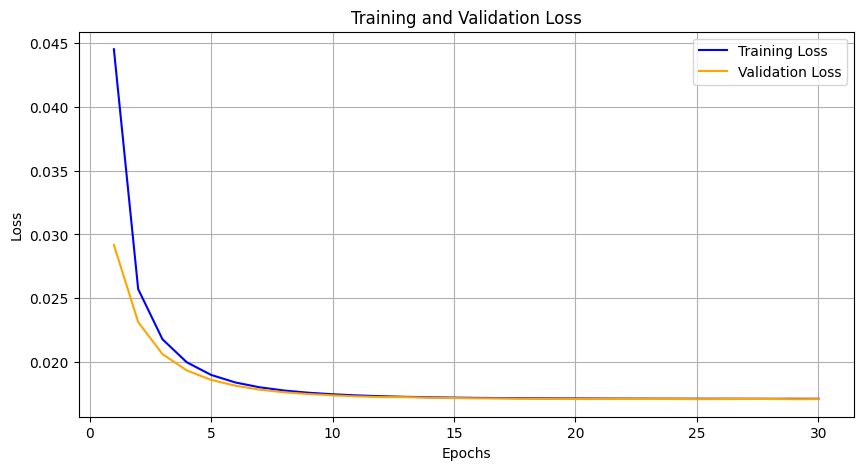

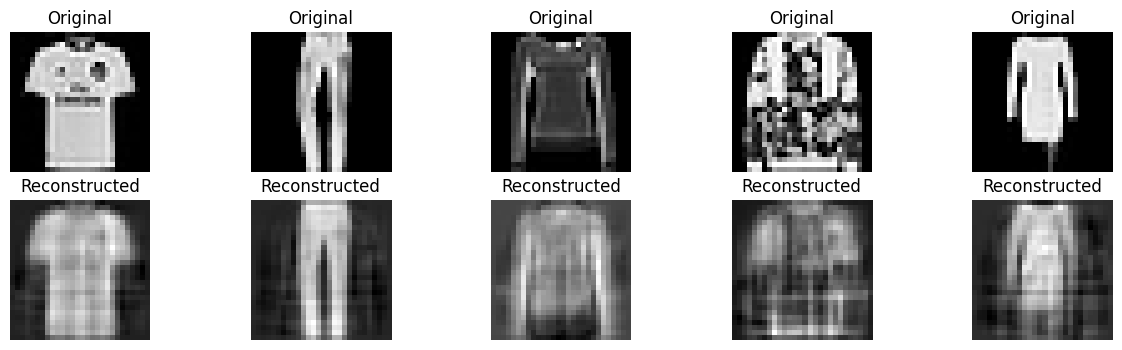

In [17]:
from AutoEncoders import AutoEncoder


input_size = 28*28
latent_size = 75
encoder_layers = []  
decoder_layers = []  
learning_rate = 0.005
max_epochs = 30
batch_size = 32

autoencoder = AutoEncoder(
    input_size=input_size,
    latent_size=latent_size,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    learning_rate=learning_rate,
    optimizer='mbgd'
)
autoencoder.fit(X_train, X_validation=X_val, max_epochs=max_epochs, batch_size=batch_size)
X_reconstructed = autoencoder.reconstruct(X_train)

import matplotlib.pyplot as plt
def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.reconstruct(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(autoencoder, X_test)

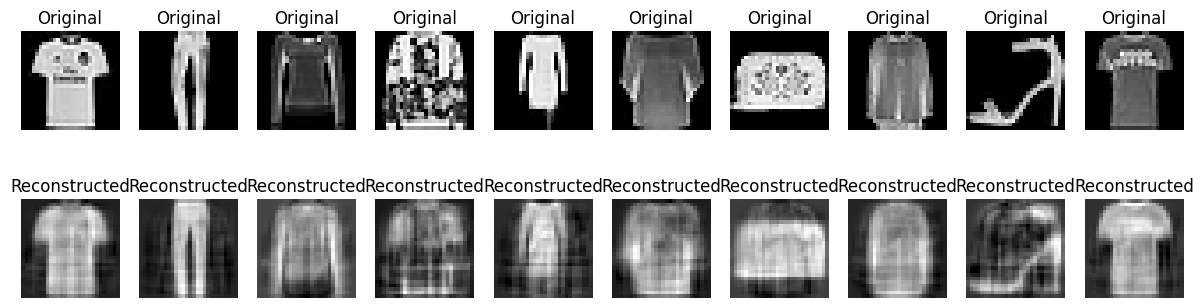

In [18]:
visualize_reconstruction(autoencoder, X_test, n_images=10)

#### Training Performance
1. **CNN Autoencoder Loss**:
   - **Final Training Loss**: 0.0045
   - **Validation Loss**: 0.0045
   - The model demonstrated consistent improvement in loss with each epoch, reaching convergence within 10 epochs.

2. **MLP Autoencoder Loss**:
   - **Final Training Loss**: 0.0171
   - **Validation Loss**: 0.0171
   - The MLP model showed a gradual reduction in loss over 30 epochs but did not reach the same level of convergence as the CNN model.

#### Validation Performance
- **Validation Loss Comparison**:
  - **CNN Autoencoder**: The validation loss started at 0.0105 and improved steadily to 0.0045 by the end of training.
  - **MLP Autoencoder**: The validation loss began at 0.0292 and decreased to 0.0171 after 30 epochs.

The CNN autoencoder exhibited faster convergence, achieving a lower validation loss [(0.0045) compared to the MLP's final validation loss (0.0171)] in significantly fewer epochs compared to the MLP's 30 epochs.

The image reconstruction quality of the MLP autoencoder is notably inferior to that of the CNN autoencoder. The MLP outputs are characterized by significant blurriness, with essential clothing features becoming less distinct. Backgrounds are noisy and cluttered, unlike CNN with crisp dark backgrounda. This is especially evident in sandal image. Additionally, T-shirt colors appear washed out, failing to preserve the vibrancy and detail of the original images.

In contrast, the CNN autoencoder effectively maintains clear structural elements and a crisp black background, allowing for better focus on the clothing items. While it smooths out finer details, it preserves essential features such as collars and sleeves, resulting in a more effective reconstruction for distinguishing clothing categories.



In [ ]:
print(X_train[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca_autoencoder import PcaAutoencoder

def plot_construction_loss(X_train, max_components=120):
    errors = []
    for n in range(60, max_components + 1):
        pca_autoencoder = PcaAutoencoder(n_components=n)
        pca_autoencoder.fit(X_train)
        error = pca_autoencoder.reconstruction_error(X_train)
        errors.append(error)

    plt.plot(range(1, max_components + 1), errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs Number of Components')
    plt.grid(True)
    plt.show()
    return errors

errors = plot_construction_loss(X_train)
print(errors)


In [ ]:

pca_autoencoder = PcaAutoencoder(n_components=75)
pca_autoencoder.fit(X_train)

def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.forward(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(pca_autoencoder, X_val)

#### KNN Classification

In [3]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'knn')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'performance_measures')))
from knn import KNN
from classification_metrics import Metrics
K_OPTIMAL = 75

In [4]:
def chunked_predict(model, X, chunk_size=5000):
    predictions = []
    for i in range(0, len(X), chunk_size):
        chunk = X[i:i + chunk_size]
        preds = model.predict(chunk)
        predictions.append(preds)
    return np.concatenate(predictions)


In [9]:
cnn_autoencoder = CNNAutoencoder(num_filters=[16, 32, K_OPTIMAL], kernel_sizes=[3, 3, 7], activation=nn.ReLU)
cnn_autoencoder.fit(train_loader, num_epochs=10)

X_train_encoded_cnn = []
X_test_encoded_cnn = []
y_train_encoded_cnn = []
y_test_encoded_cnn = []

cnn_autoencoder.eval()

with torch.no_grad():
    for x, y in train_loader: 
        x = x.to(device)
        encoded = cnn_autoencoder.encode(x)
        X_train_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())
        y_train_encoded_cnn.append(y.numpy()) 

    for x, y in test_loader: 
        x = x.to(device)
        encoded = cnn_autoencoder.encode(x)
        X_test_encoded_cnn.append(encoded.view(encoded.size(0), -1).cpu().numpy())
        y_test_encoded_cnn.append(y.numpy()) 

X_train_encoded_cnn = np.concatenate(X_train_encoded_cnn)
X_test_encoded_cnn = np.concatenate(X_test_encoded_cnn)
y_train_encoded_cnn = np.concatenate(y_train_encoded_cnn) 
y_test_encoded_cnn = np.concatenate(y_test_encoded_cnn)


Epoch [1/10]: 100%|██████████| 1563/1563 [00:26<00:00, 59.91batch/s]


Epoch [1/10], Loss: 0.0160


Epoch [2/10]: 100%|██████████| 1563/1563 [00:28<00:00, 55.41batch/s]


Epoch [2/10], Loss: 0.0066


Epoch [3/10]: 100%|██████████| 1563/1563 [00:29<00:00, 52.81batch/s]


Epoch [3/10], Loss: 0.0052


Epoch [4/10]: 100%|██████████| 1563/1563 [00:30<00:00, 50.57batch/s]


Epoch [4/10], Loss: 0.0046


Epoch [5/10]: 100%|██████████| 1563/1563 [00:37<00:00, 41.57batch/s]


Epoch [5/10], Loss: 0.0042


Epoch [6/10]: 100%|██████████| 1563/1563 [00:37<00:00, 41.98batch/s]


Epoch [6/10], Loss: 0.0040


Epoch [7/10]: 100%|██████████| 1563/1563 [00:35<00:00, 44.23batch/s]


Epoch [7/10], Loss: 0.0038


Epoch [8/10]: 100%|██████████| 1563/1563 [00:38<00:00, 40.87batch/s]


Epoch [8/10], Loss: 0.0037


Epoch [9/10]: 100%|██████████| 1563/1563 [00:37<00:00, 42.03batch/s]


Epoch [9/10], Loss: 0.0036


Epoch [10/10]: 100%|██████████| 1563/1563 [00:38<00:00, 40.17batch/s]


Epoch [10/10], Loss: 0.0035


In [10]:
knn_cnn = KNN(k=5, distance_metric='cosine')
knn_cnn.fit(X_train_encoded_cnn, y_train_encoded_cnn)

y_pred_on_train_cnn = chunked_predict(knn_cnn,X_train_encoded_cnn)
y_pred_on_test_cnn = chunked_predict(knn_cnn,X_test_encoded_cnn)

train_scores_cnn = Metrics(y_train_encoded_cnn, y_pred_on_train_cnn, task='classification')
test_scores_cnn = Metrics(y_test_encoded_cnn, y_pred_on_test_cnn, task='classification')

train_accuracy_cnn = train_scores_cnn.accuracy()
test_accuracy_cnn = test_scores_cnn.accuracy()

print(f"Train Accuracy of KNN with CNN Autoencoder: {train_accuracy_cnn:.5f}")
print(f"Test Accuracy of KNN with CNN Autoencoder: {test_accuracy_cnn:.5f}")

Train Accuracy of KNN with CNN Autoencoder: 0.91524
Test Accuracy of KNN with CNN Autoencoder: 0.87800


In [33]:
from pca_autoencoder import PcaAutoencoder
pca_autoencoder_knn = PcaAutoencoder(n_components=K_OPTIMAL)
pca_autoencoder_knn.fit(X_train)

X_train_encoded_pca = pca_autoencoder_knn.encode(X_train)
X_test_encoded_pca = pca_autoencoder_knn.encode(X_test)

In [ ]:
knn_pca = KNN(k=5, distance_metric='cosine')
knn_pca.fit(X_train_encoded_pca, y_train)

y_pred_on_train_pca = chunked_predict(knn_pca,X_train_encoded_pca)
y_pred_on_test_pca = chunked_predict(knn_pca,X_test_encoded_pca)

train_scores_pca = Metrics(y_train, y_pred_on_train_pca, task='classification')
test_scores_pca = Metrics(y_test, y_pred_on_test_pca, task='classification')

train_accuracy_pca = train_scores_pca.accuracy()
test_accuracy_pca = test_scores_pca.accuracy()

print(f"Train Accuracy of KNN with PCA Autoencoder: {train_accuracy_pca:.5f}")
print(f"Test Accuracy of KNN with PCA Autoencoder: {test_accuracy_pca:.5f}")

Train Accuracy of KNN with PCA Autoencoder: 0.90382


In [5]:
from AutoEncoders import AutoEncoder


input_size = 28*28
latent_size = K_OPTIMAL
encoder_layers = []  
decoder_layers = []  
learning_rate = 0.01
max_epochs = 20
batch_size = 32

mlp_autoencoder_knn = AutoEncoder(
    input_size=input_size,
    latent_size=latent_size,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    learning_rate=learning_rate,
    optimizer='sgd'
)
print(X_train.shape)
mlp_autoencoder_knn.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
X_train_encoded_mlp = mlp_autoencoder_knn.get_latent(X_train)
X_test_encoded_mlp = mlp_autoencoder_knn.get_latent(X_test)

(50000, 784)
Epoch 1/20, Loss: 0.03527552569864907
Epoch 2/20, Loss: 0.020954353880839247
Epoch 3/20, Loss: 0.018760958442633813
Epoch 4/20, Loss: 0.017960207499644255
Epoch 5/20, Loss: 0.01759598351781362
Epoch 6/20, Loss: 0.017412964551129066
Epoch 7/20, Loss: 0.017316237118311067
Epoch 8/20, Loss: 0.017260665126982013
Epoch 9/20, Loss: 0.017229339568043657
Epoch 10/20, Loss: 0.017210066472636353
Epoch 11/20, Loss: 0.01719583941098912
Epoch 12/20, Loss: 0.017189918650713475
Epoch 13/20, Loss: 0.017185335510811434
Epoch 14/20, Loss: 0.017184096331290248
Epoch 15/20, Loss: 0.017180737974069386
Epoch 16/20, Loss: 0.017177516093531707
Epoch 17/20, Loss: 0.017178746523859197
Epoch 18/20, Loss: 0.01717828671556896
Epoch 19/20, Loss: 0.01717666472649562
Epoch 20/20, Loss: 0.01717654615754755


In [ ]:
knn_mlp = KNN(k=5, distance_metric='cosine')
knn_mlp.fit(X_train_encoded_mlp, y_train)

y_pred_on_train_mlp = chunked_predict(knn_mlp,X_train_encoded_mlp)
y_pred_on_test_mlp = chunked_predict(knn_mlp,X_test_encoded_mlp)

train_scores_mlp = Metrics(y_train, y_pred_on_train_mlp, task='classification')
test_scores_mlp = Metrics(y_test, y_pred_on_test_mlp, task='classification')

train_accuracy_mlp = train_scores_mlp.accuracy()
test_accuracy_mlp = test_scores_mlp.accuracy()

print(f"Train Accuracy of KNN with MLP Autoencoder: {train_accuracy_mlp:.5f}")
print(f"Test Accuracy of KNN with MLP Autoencoder: {test_accuracy_mlp:.5f}")

Train Accuracy of KNN with MLP Autoencoder: 0.88860
Test Accuracy of KNN with MLP Autoencoder: 0.84620


In [40]:

# accuracies = {
#     'CNN': (train_scores_cnn.accuracy(), test_scores_cnn.accuracy()),
#     'PCA': (train_scores_pca.accuracy(), test_scores_pca.accuracy()),
#     'MLP': (train_scores_mlp.accuracy(), test_scores_mlp.accuracy())
# }

accuracies = {
    'CNN': (0.91, 0.88380),
    'PCA': (0.90382, 0.86600),
    'MLP': (0.8886, 0.8462)
}

print(accuracies)




{'CNN': (0.91, 0.8838), 'PCA': (0.90382, 0.866), 'MLP': (0.8886, 0.8462)}


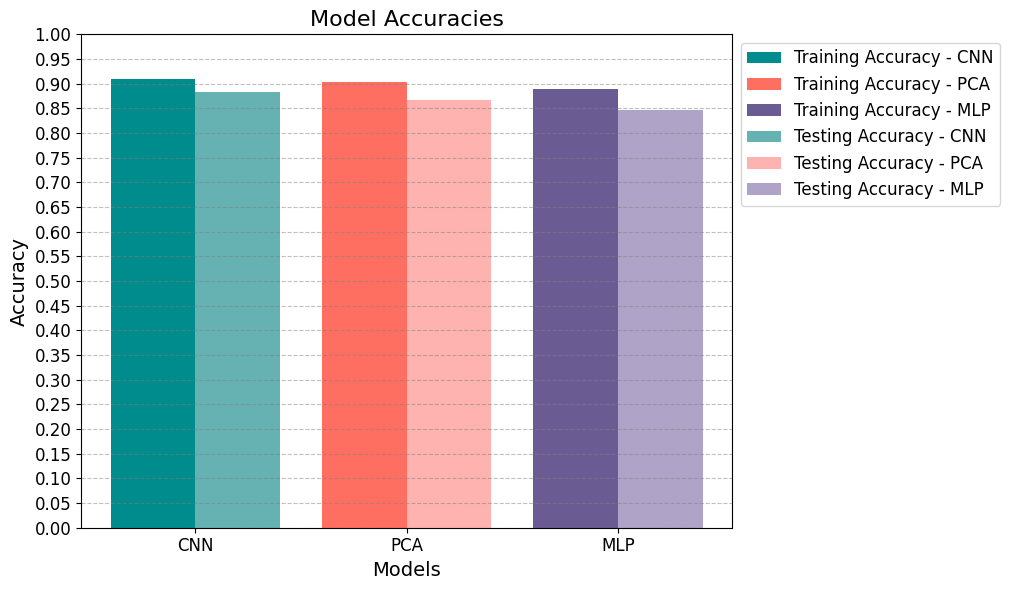

In [41]:
import matplotlib.pyplot as plt

colors = {
    'CNN': ('#008C8C', '#66B2B2'),
    'PCA': ('#FF6F61', '#FFB3B0'),
    'MLP': ('#6B5B93', '#AFA4C8')   
}

models = list(accuracies.keys())
train_accuracies = [acc[0] for acc in accuracies.values()]
test_accuracies = [acc[1] for acc in accuracies.values()]
x = range(len(models))

plt.figure(figsize=(12, 6))

for i, model in enumerate(models):
    plt.bar(x[i], train_accuracies[i], width=0.4, 
            label=f'Training Accuracy - {model}', color=colors[model][0])

for i, model in enumerate(models):
    plt.bar(x[i] + 0.4, test_accuracies[i], width=0.4, 
            label=f'Testing Accuracy - {model}', color=colors[model][1])

plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracies', fontsize=16)
plt.xticks([p + 0.2 for p in x], models, fontsize=12)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

plt.yticks([i * 0.05 for i in range(21)], fontsize=12)

plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()


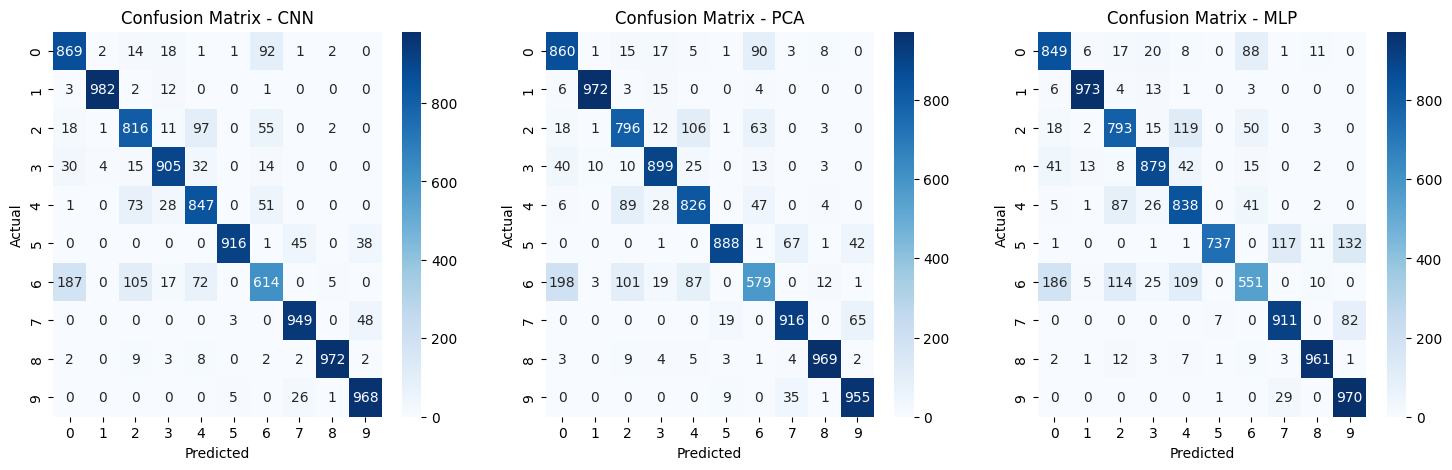

In [36]:
import seaborn as sns

confusion_cnn = test_scores_cnn.confusion_matrix()
confusion_pca = test_scores_pca.confusion_matrix()
confusion_mlp = test_scores_mlp.confusion_matrix()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.heatmap(confusion_cnn, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - CNN')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_pca, annot=True, fmt="d", ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - PCA')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

sns.heatmap(confusion_mlp, annot=True, fmt="d", ax=axes[2], cmap='Blues')
axes[2].set_title('Confusion Matrix - MLP')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.show()
